# Import libraries

In [1]:
import boto3
import pandas as pd
import numpy as np
import io
from sagemaker import get_execution_role
import os

# Amazon SageMaker Python SDK
import sagemaker.amazon.common as smac 
import sagemaker

# instruction to Jupyter to inline all the visualizations
%matplotlib inline 

# Data Ingestion

Next, we read the dataset from an online URL into memory, for preprocessing prior to training.

In [2]:
role = get_execution_role()
input_bucket = 'linkedin-sagemaker'
in_data_key = 'crime-data.csv'
training_data_location = 's3://{}/{}'.format(input_bucket, in_data_key)

# Define the headers since the data does not have any
headers = ['CommittedCrime','County','TimeofDay','DayofWeek','Month','Gender','AverageAge']

df = pd.read_csv(training_data_location, names=headers)
print('uploaded training data from location: {}'.format(training_data_location))

uploaded training data from location: s3://linkedin-sagemaker/crime-data.csv


# Data Inspection & Visualization

Once the dataset is imported, it's typical as part of the machine learning process to inspect the data, understand the distributions, and determine what type(s) of preprocessing might be needed.

In [3]:
#inspect the data
df

,CommittedCrime,County,TimeofDay,DayofWeek,Month,Gender,AverageAge
0,1,DevonCornwall,morning,Sunday,January,Male,48.0
1,1,DevonCornwall,afternoon,Sunday,January,Male,21.0
2,1,DevonCornwall,morning,Thursday,January,Male,30.0
3,1,DevonCornwall,morning,Thursday,January,Female,48.0
4,1,DevonCornwall,afternoon,Friday,January,Female,30.0
5,1,DevonCornwall,afternoon,Saturday,January,Male,48.0
6,1,DevonCornwall,evening,Saturday,January,Male,21.0
7,1,DevonCornwall,evening,Sunday,January,Male,21.0
8,1,DevonCornwall,evening,Monday,January,Male,21.0
9,1,DevonCornwall,morning,Tuesday,January,Male,30.0


In [4]:
# So if I say df.Quantity,
#that's going to give me a single column of data,
#which is the quantities of the different transactions
#in donuts that we had.
df.County

0        DevonCornwall
1        DevonCornwall
2        DevonCornwall
3        DevonCornwall
4        DevonCornwall
5        DevonCornwall
6        DevonCornwall
7        DevonCornwall
8        DevonCornwall
9        DevonCornwall
10       DevonCornwall
11       DevonCornwall
12       DevonCornwall
13       DevonCornwall
14       DevonCornwall
15       DevonCornwall
16       DevonCornwall
17       DevonCornwall
18       DevonCornwall
19       DevonCornwall
20       DevonCornwall
21       DevonCornwall
22       DevonCornwall
23       DevonCornwall
24       DevonCornwall
25       DevonCornwall
26       DevonCornwall
27       DevonCornwall
28       DevonCornwall
29       DevonCornwall
             ...      
10835           Dorset
10836           Dorset
10837           Dorset
10838           Dorset
10839           Dorset
10840           Dorset
10841           Dorset
10842           Dorset
10843           Dorset
10844           Dorset
10845           Dorset
10846           Dorset
10847      

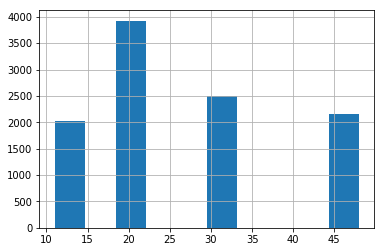

In [5]:
df.AverageAge.hist()

In [6]:
#select a subset of records
df[df.TimeofDay == 'morning']

,CommittedCrime,County,TimeofDay,DayofWeek,Month,Gender,AverageAge
0,1,DevonCornwall,morning,Sunday,January,Male,48.0
2,1,DevonCornwall,morning,Thursday,January,Male,30.0
3,1,DevonCornwall,morning,Thursday,January,Female,48.0
9,1,DevonCornwall,morning,Tuesday,January,Male,30.0
20,1,DevonCornwall,morning,Sunday,January,Male,48.0
25,1,DevonCornwall,morning,Tuesday,January,Male,48.0
26,1,DevonCornwall,morning,Wednesday,January,Male,48.0
30,1,DevonCornwall,morning,Sunday,January,Male,11.0
31,1,Surrey,morning,Sunday,January,Male,21.0
32,1,Surrey,morning,Sunday,January,Male,21.0


In [7]:
#look at relationship among different columns
#this shows the count of each county by committed crime
#So for Kent, 235 records where no crime and 365 records where there is crime
#So for Surrey, 437 no crime, 473 crime
pd.crosstab(df.County,df.CommittedCrime)

CommittedCrime,0,1
County,,
DevonCornwall,776,423
Dorset,259,143
Essex,762,427
Hampshire,1621,1992
Kent,1401,1551
Nottinghamshire,235,365
Surrey,437,473


In [8]:
pd.crosstab(df.Gender,df.CommittedCrime)

CommittedCrime,0,1
Gender,,
Female,649,589
Male,4724,4715
Other,16,13


# Data Cleaning

Get rid of null or bad values

In [9]:
#Records that need to be removed because they are null or empty
df.isnull().sum()

CommittedCrime      0
County              0
TimeofDay           0
DayofWeek           0
Month               0
Gender            159
AverageAge        272
dtype: int64

In [10]:
#View Age records that are NaN
#In the cases where there aren't any transactions, it puts in a value of not a number.
df[df.AverageAge.isnull()]

,CommittedCrime,County,TimeofDay,DayofWeek,Month,Gender,AverageAge
42,1,Surrey,evening,Thursday,January,NaN,NaN
87,1,Essex,afternoon,Wednesday,January,NaN,NaN
101,1,Essex,afternoon,Wednesday,January,NaN,NaN
431,1,Nottinghamshire,morning,Sunday,January,NaN,NaN
434,1,Nottinghamshire,morning,Monday,January,NaN,NaN
440,1,Nottinghamshire,morning,Friday,January,NaN,NaN
447,1,Nottinghamshire,afternoon,Wednesday,January,Male,NaN
448,1,Nottinghamshire,morning,Friday,January,Male,NaN
486,1,DevonCornwall,morning,Sunday,February,Male,NaN
493,1,DevonCornwall,afternoon,Tuesday,February,Male,NaN


In [11]:
#REMOVE AGE RECORDS THAT ARE NaN
df.dropna(subset=['AverageAge'], inplace=True)

#double check to see removed
df['AverageAge'].isnull().sum()

0

In [12]:
#Show the records with null or other
df[ (df.Gender == 'Other') | (df.Gender.isnull())]

,CommittedCrime,County,TimeofDay,DayofWeek,Month,Gender,AverageAge
467,1,DevonCornwall,morning,Friday,February,NaN,48.0
569,1,Hampshire,afternoon,Wednesday,February,Other,21.0
892,1,DevonCornwall,morning,Friday,March,NaN,30.0
1361,1,DevonCornwall,morning,Friday,April,NaN,30.0
1419,1,Hampshire,afternoon,Sunday,April,Other,11.0
2614,1,DevonCornwall,afternoon,Tuesday,July,NaN,48.0
2629,1,DevonCornwall,morning,Monday,July,NaN,30.0
2747,1,Hampshire,afternoon,Friday,July,Other,30.0
2802,1,Hampshire,evening,Saturday,July,Other,30.0
3077,1,DevonCornwall,afternoon,Wednesday,August,NaN,30.0


In [13]:
#Remove the null records for Gender
df.dropna(subset=['Gender'], inplace=True)

#double check to see removed
df['Gender'].isnull().sum()

0

In [14]:
#show the records with Gender as Other
#NOTE: seems to be a common pattern with police in Hampshire when collecting data; they don't add a gender
df[(df.Gender == 'Other')]

,CommittedCrime,County,TimeofDay,DayofWeek,Month,Gender,AverageAge
569,1,Hampshire,afternoon,Wednesday,February,Other,21.0
1419,1,Hampshire,afternoon,Sunday,April,Other,11.0
2747,1,Hampshire,afternoon,Friday,July,Other,30.0
2802,1,Hampshire,evening,Saturday,July,Other,30.0
3749,1,Hampshire,evening,Friday,September,Other,21.0
7758,0,Hampshire,morning,Wednesday,February,Other,21.0
7899,0,Hampshire,evening,Thursday,February,Other,21.0
8071,0,Hampshire,evening,Saturday,February,Other,11.0
8072,0,Hampshire,evening,Saturday,February,Other,11.0
9789,0,Hampshire,evening,Saturday,March,Other,11.0


In [15]:
#Remove the records that are 'Other' for Gender
#NOTE: Make sure to assign back the updated data frame
df = df[df.Gender != 'Other']

#double check to see if removed
df[(df.Gender == 'Other')]

,CommittedCrime,County,TimeofDay,DayofWeek,Month,Gender,AverageAge


In [16]:
#Let's look at dataframe again that contains the cleaned data
df

,CommittedCrime,County,TimeofDay,DayofWeek,Month,Gender,AverageAge
0,1,DevonCornwall,morning,Sunday,January,Male,48.0
1,1,DevonCornwall,afternoon,Sunday,January,Male,21.0
2,1,DevonCornwall,morning,Thursday,January,Male,30.0
3,1,DevonCornwall,morning,Thursday,January,Female,48.0
4,1,DevonCornwall,afternoon,Friday,January,Female,30.0
5,1,DevonCornwall,afternoon,Saturday,January,Male,48.0
6,1,DevonCornwall,evening,Saturday,January,Male,21.0
7,1,DevonCornwall,evening,Sunday,January,Male,21.0
8,1,DevonCornwall,evening,Monday,January,Male,21.0
9,1,DevonCornwall,morning,Tuesday,January,Male,30.0


# Data Encoding & Transformation

Before you start training, you first need to prepare the data because classifiers only work with numerical values. Let's convert the categorical features into numeric features. 

In [17]:
#check to see the data types we have
df.dtypes

CommittedCrime      int64
County             object
TimeofDay          object
DayofWeek          object
Month              object
Gender             object
AverageAge        float64
dtype: object

In [18]:
#Use "find and replace" method to convert text to string
#Day of Week is easily translated to valid numbers - Monday is 1, Tuesday is 2, Wednesday is 3.....
#Month is easily translated to valid numbers - January is 1, February 2, March is 3 ......
#Gender is easily translated to valid numbers - 1 is Male, 2 is Female
convert_nums = {"DayofWeek": {"Monday": 1, 
                              "Tuesday": 2,
                              "Wednesday": 3,
                              "Thursday": 4,
                              "Friday": 5,
                              "Saturday": 6,
                              "Sunday": 7},
                "Month": {"January": 1, 
                          "February": 2, 
                          "March": 3, 
                          "April": 4,
                          "May": 5, 
                          "June": 6, 
                          "July": 7, 
                          "August": 8, 
                          "September": 9, 
                          "October": 10, 
                          "November": 11, 
                          "December": 12}}


#turn off copy warning
df.is_copy = False

#convert the columns to numbers using replace
df.replace(convert_nums, inplace=True)
df.head()

,CommittedCrime,County,TimeofDay,DayofWeek,Month,Gender,AverageAge
0,1,DevonCornwall,morning,7,1,Male,48.0
1,1,DevonCornwall,afternoon,7,1,Male,21.0
2,1,DevonCornwall,morning,4,1,Male,30.0
3,1,DevonCornwall,morning,4,1,Female,48.0
4,1,DevonCornwall,afternoon,5,1,Female,30.0


In [19]:
#Use "One Hot Encoding" method on values that can't be easily translated to a numeric value
#Convert each category value into a new column and assigns a 1 or 0 (True/False) value to the column. 
#This has the benefit of not weighting a value improperly but does add more columns to the data set.
#Pandas supports this feature using get_dummies. This function is named this way because 
#it creates dummy/indicator variables (aka 1 or 0)


#List all the unique values for Gender
df.Gender.unique()

array(['Male', 'Female'], dtype=object)

In [20]:
#Convert using get_dummies; goes from 1 column to 2 with a 1 or 0 corresponding to the correct value
df = pd.get_dummies(df, columns=["Gender"])
df

,CommittedCrime,County,TimeofDay,DayofWeek,Month,AverageAge,Gender_Female,Gender_Male
0,1,DevonCornwall,morning,7,1,48.0,0,1
1,1,DevonCornwall,afternoon,7,1,21.0,0,1
2,1,DevonCornwall,morning,4,1,30.0,0,1
3,1,DevonCornwall,morning,4,1,48.0,1,0
4,1,DevonCornwall,afternoon,5,1,30.0,1,0
5,1,DevonCornwall,afternoon,6,1,48.0,0,1
6,1,DevonCornwall,evening,6,1,21.0,0,1
7,1,DevonCornwall,evening,7,1,21.0,0,1
8,1,DevonCornwall,evening,1,1,21.0,0,1
9,1,DevonCornwall,morning,2,1,30.0,0,1


In [21]:
#List all the unique values for TimeofDay
df.TimeofDay.unique()

array(['morning', 'afternoon', 'evening'], dtype=object)

In [22]:
#Convert using get_dummies; goes from 1 column to 3 with a 1 or 0 corresponding to the correct value
df = pd.get_dummies(df, columns=["TimeofDay"])
df

,CommittedCrime,County,DayofWeek,Month,AverageAge,Gender_Female,Gender_Male,TimeofDay_afternoon,TimeofDay_evening,TimeofDay_morning
0,1,DevonCornwall,7,1,48.0,0,1,0,0,1
1,1,DevonCornwall,7,1,21.0,0,1,1,0,0
2,1,DevonCornwall,4,1,30.0,0,1,0,0,1
3,1,DevonCornwall,4,1,48.0,1,0,0,0,1
4,1,DevonCornwall,5,1,30.0,1,0,1,0,0
5,1,DevonCornwall,6,1,48.0,0,1,1,0,0
6,1,DevonCornwall,6,1,21.0,0,1,0,1,0
7,1,DevonCornwall,7,1,21.0,0,1,0,1,0
8,1,DevonCornwall,1,1,21.0,0,1,0,1,0
9,1,DevonCornwall,2,1,30.0,0,1,0,0,1


In [23]:
#List all the unique values for County
df.County.unique()

array(['DevonCornwall', 'Surrey', 'Essex', 'Hampshire', 'Kent',
       'Nottinghamshire', 'Dorset'], dtype=object)

In [24]:
#Convert using get_dummies; goes from 1 column to 7 with a 1 or 0 corresponding to the correct value
df = pd.get_dummies(df, columns=["County"])
df

,CommittedCrime,DayofWeek,Month,AverageAge,Gender_Female,Gender_Male,TimeofDay_afternoon,TimeofDay_evening,TimeofDay_morning,County_DevonCornwall,County_Dorset,County_Essex,County_Hampshire,County_Kent,County_Nottinghamshire,County_Surrey
0,1,7,1,48.0,0,1,0,0,1,1,0,0,0,0,0,0
1,1,7,1,21.0,0,1,1,0,0,1,0,0,0,0,0,0
2,1,4,1,30.0,0,1,0,0,1,1,0,0,0,0,0,0
3,1,4,1,48.0,1,0,0,0,1,1,0,0,0,0,0,0
4,1,5,1,30.0,1,0,1,0,0,1,0,0,0,0,0,0
5,1,6,1,48.0,0,1,1,0,0,1,0,0,0,0,0,0
6,1,6,1,21.0,0,1,0,1,0,1,0,0,0,0,0,0
7,1,7,1,21.0,0,1,0,1,0,1,0,0,0,0,0,0
8,1,1,1,21.0,0,1,0,1,0,1,0,0,0,0,0,0
9,1,2,1,30.0,0,1,0,0,1,1,0,0,0,0,0,0


# Splitting into Training, Test and Validation Sets
This will help prevent us from overfitting the model, and allow us to test the models accuracy on data it hasn't already seen.

In [25]:
# convert dataframe to csv; save the original cleaned file to notebook instance
df.to_csv('crime-data-cleaned.csv', header=False, index=False)

# Split the data for training, validation, and test into separate dataframes
# produces a 60%, 20%, 20% split for training, validation and test sets
train_data, validation_data, test_data = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

#convert dfs to .csv and save locally; file is saved to notebook instance
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)
test_data.to_csv('test.csv', header=False, index=False)

# Upload Training Data to S3
Now that we've created our CSV files, we'll need to upload them to S3, so that Amazon SageMaker training can use it.

In [26]:
# load files to S3
# The S3 bucket, prefix, and file name that you want to use for training and model data 
output_bucket = 'linkedin-sagemaker'
prefix = 'cleaned'

boto3.resource('s3').Bucket(output_bucket).Object(os.path.join(prefix, 'crime-data-cleaned.csv')).upload_file('crime-data-cleaned.csv')
boto3.resource('s3').Bucket(output_bucket).Object(os.path.join(prefix, 'train.csv')).upload_file('train.csv')
boto3.resource('s3').Bucket(output_bucket).Object(os.path.join(prefix, 'validation.csv')).upload_file('validation.csv')
boto3.resource('s3').Bucket(output_bucket).Object(os.path.join(prefix, 'test.csv')).upload_file('test.csv')